In [24]:
from ase.io import read, write
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from rascal.representations import SphericalInvariants as SOAP
from feature_utils.parallel import get_features_in_parallel
import json 
from joblib import load
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from copy import deepcopy

In [25]:
import time 

In [26]:
x = set(np.array([1,6,7,8,16]))
y = set([1,6,7,8,16])
x.issubset(y) 

True

In [27]:
model_fitted_for_species = set([1,6,7,8,16])

def small_model(READPATH,WRITEPATH,fit_species=None,nthreads=-1):
    
    trajframes = read(READPATH,format="extxyz",index=":")    
    for frame in trajframes: frame.wrap(eps=1e-12)
    for frame in trajframes: frame.arrays.pop("center_atoms_mask",None)
    
    if len(trajframes) == 0:
        print("empty frames")
        return
    
    species_indices = [frame.numbers for frame in trajframes]
    
    if not np.all(species_indices == trajframes[0].numbers):
        print("ordering or length has changed of frames")
        return
    
    species_indices = np.concatenate([frame.numbers for frame in trajframes])
    shifts = np.full(species_indices.shape, np.NaN)
    species = set(np.unique(species_indices))
    
    
    
    if not species.issubset(model_fitted_for_species):
        print("sorry, model has only been fitted for H,C,N,O and S containing structures")
        return
    
    if fit_species is None:
        fit_species = list(species)
        
    if not set(fit_species).issubset(species):
        print("species not contained in structures")
        return
    
    
    for specie in fit_species:
        fit_frames = deepcopy(trajframes)
    
        for frame in fit_frames: mask_center_atoms_by_species(frame,[int(specie)]) 
        
        f = open("../ShiftML-Light/data/RR_this_work_models/hypers/{}_hypers.json".format(specie))
        hypers = json.load(f)

        model = load("../ShiftML-Light/data/RR_this_work_models/{}_RR.joblib".format(specie))
        Xpredict = get_features_in_parallel(fit_frames,SOAP,hypers,n_cores=nthreads)
        Ypred = model.predict(Xpredict)
        shifts[species_indices==specie] = Ypred
    
    
    for frame_shift, frame in zip(np.split(shifts,len(trajframes)),trajframes):
        frame.arrays["cs_iso"] = frame_shift
    
    write(WRITEPATH,trajframes,format="extxyz")
    
    
    
    

In [72]:
import cProfile

In [73]:
cProfile.run("small_model(\"./example_trajectories/test_traj.xyz\",\"\")")

         930191 function calls (868855 primitive calls) in 3.265 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 3697577630.py:12(<listcomp>)
        1    0.000    0.000    0.000    0.000 3697577630.py:18(<listcomp>)
        1    0.020    0.020    3.265    3.265 3697577630.py:3(small_model)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(all)
      451    0.000    0.000    0.002    0.000 <__array_function__ internals>:2(atleast_2d)
      454    0.000    0.000    0.176    0.000 <__array_function__ internals>:2(concatenate)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
      451    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(dot)
     1804    0.001    0.000    0.011    0.000 <__array_function__ internals>:2(in1d)
     1804    0.001    0.000    0.017    0.000 <__array_function__ internals>

In [18]:
#trajframes = read("./example_trajectories/test_traj.xyz",format="extxyz",index=":")  
#print(len(trajframes))
#for frame in trajframes: frame.wrap(eps=1e-12)
#for frame in trajframes: frame.arrays.pop("center_atoms_mask",None)
#model = load("./RR_this_work_models/{}_RR.joblib".format(6))
#for frame in trajframes: mask_center_atoms_by_species(frame,[6]) 
#f = open("./RR_this_work_models/hypers/{}_hypers.json".format(6))
#hypers = json.load(f)
#X = get_features_in_parallel(trajframes,SOAP,hypers)
#yKRR = np.concatenate([structure.arrays["CS"][structure.arrays["center_atoms_mask"]] for structure in trajframes])
#Ypred_wo = model.predict(X)

trajframes = read("./example_trajectories/test_traj_w_cs.xyz",format="extxyz",index=":")  
for frame in trajframes: frame.wrap(eps=1e-12)
for frame in trajframes: frame.arrays.pop("center_atoms_mask",None)
model = load("../ShiftML-Light/data/RR_this_work_models/{}_RR.joblib".format(1))
for frame in trajframes: mask_center_atoms_by_species(frame,[1]) 
f = open("../ShiftML-Light/data/RR_this_work_models/hypers/{}_hypers.json".format(1))
hypers = json.load(f)
X = get_features_in_parallel(trajframes,SOAP,hypers)
#yKRR = np.concatenate([structure.arrays["CS"][structure.arrays["center_atoms_mask"]] for structure in trajframes])
Ypred_w = model.predict(X)

In [5]:
trajframes = read("./example_trajectories/test_traj_w_cs.xyz",format="extxyz",index=":")  

In [8]:
trajframes[0].arrays.keys()

dict_keys(['numbers', 'positions', 'CS', 'CSerr', 'CSens', 'center_atoms_mask'])

In [6]:
len(trajframes)

451

In [13]:
import matplotlib.pyplot as plt

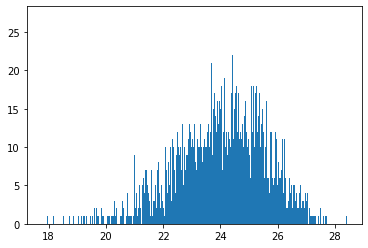

In [19]:
#_ = plt.hist(Ypred_wo,bins=1000)
_ = plt.hist(Ypred_w,bins=1000)

In [14]:
trajframes[0].arrays.keys()

dict_keys(['numbers', 'positions'])

In [22]:
small_model("./example_trajectories/test_traj_w_cs.xyz","./example_trajectories/with_smallml_shifts.xyz")

In [17]:
from matplotlib import pyplot as plt

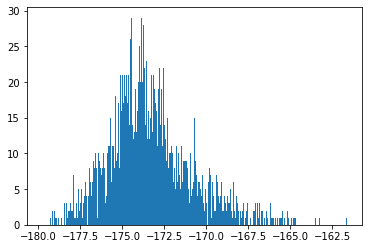

In [24]:
_ = plt.hist(che_shift[1],bins=1000)
#plt.xlim(0,100)

In [171]:
len(trajframes)

451

In [154]:
"./example_trajectories/test_traj_w_cs.xyz"

'./example_trajectories/test_traj_w_cs.xyz'

In [155]:
small_model("./example_trajectories/test_traj_w_cs.xyz","","")

In [145]:
species_indices = [frame.numbers for frame in trajframes]

In [149]:
np.all(species_indices == trajframes[0].numbers)

True

In [146]:
species_indices 

[array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([6,

In [173]:
shifts[1][0]

array([[33.50676972],
       [43.48177098],
       [32.19435233],
       ...,
       [23.65793392],
       [23.80731305],
       [22.91030028]])

In [23]:
import pandas as pd

In [28]:
species = [1,6]
shifts = {1:[],6:[]}
for specie in species: 
    trajframes = read("./example_trajectories/test_traj_w_cs.xyz",format="extxyz",index=":")
    for frame in trajframes: frame.wrap(eps=1e-12)
    for frame in trajframes: frame.arrays.pop("center_atoms_mask",None)
    for frame in trajframes: mask_center_atoms_by_species(frame,[specie])
    yKRR = train_properties = np.concatenate([structure.arrays["CS"][structure.arrays["center_atoms_mask"]] for structure in trajframes])
    f = open("../ShiftML-Light/data/RR_this_work_models/hypers/{}_hypers.json".format(specie))
    hypers = json.load(f)
    model = load("../ShiftML-Light/data/RR_this_work_models/{}_RR.joblib".format(specie))
    Xpred = get_features_in_parallel(trajframes,SOAP,hypers)
    RR_pred = model.predict(Xpred)
    shifts[specie].append(yKRR.reshape(-1,1))
    shifts[specie].append(RR_pred.reshape(-1,1))

Text(0.5, 0, '13C chemical shift [ppm]')

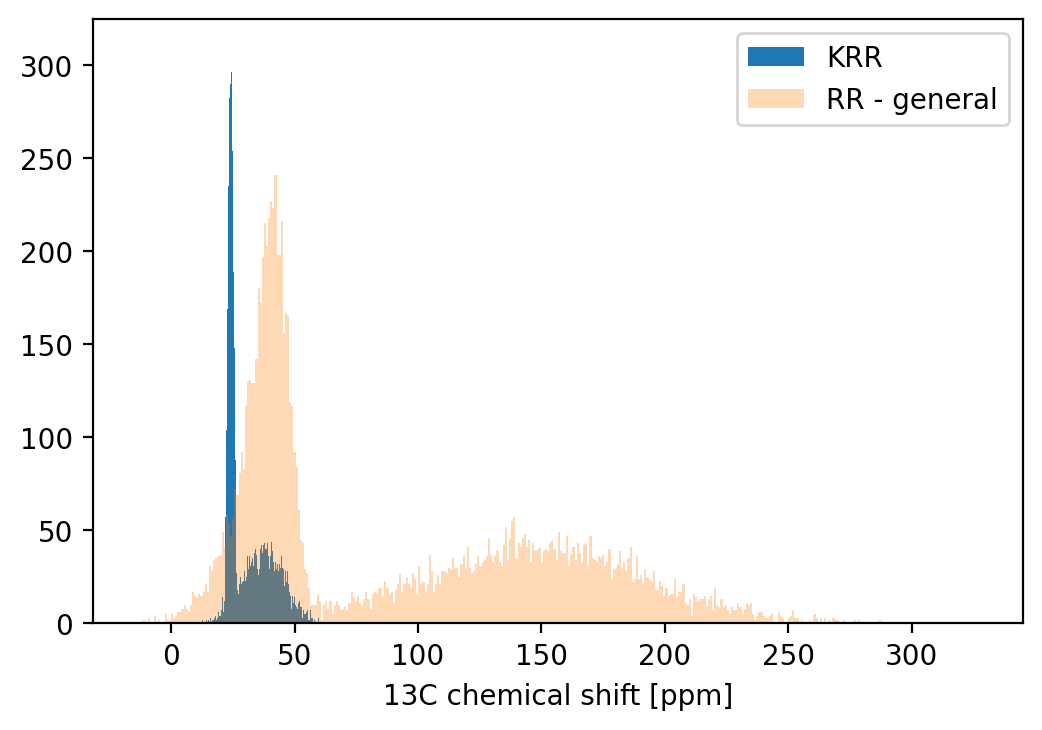

In [208]:
plt.figure(dpi=200)
_ = plt.hist(shifts[1][0],bins=400,label="KRR")
_ = plt.hist(shifts[1][1],bins=400,label="RR - general",alpha=0.3)
plt.legend()
plt.xlabel("13C chemical shift [ppm]")
#plt.savefig("1H_test",dpi=200)

In [102]:
shifts_np = 

In [103]:
shifts_np.shape

(10824, 2)

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
shifts_H = pd.DataFrame(np.concatenate(shifts[1], axis=1), columns=["1H shift KRR","1H shift RR - general"])
shifts_C = pd.DataFrame(np.concatenate(shifts[6], axis=1), columns=["13C shift KRR","13C shift RR - general"])

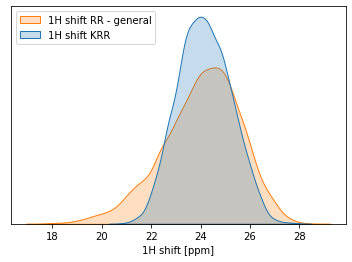

In [30]:
import seaborn as sns
shifts_pd = pd.DataFrame(np.concatenate(shifts[1],axis=1), columns=["KRR","RR"])
label_dict = {"1":None,"6":"13C shift [ppm]"}
fig, ax = plt.subplots()
sns.kdeplot(data=shifts_pd,fill=True,color="orange", ax=ax,common_norm=False,log_scale=(False,False))
#sns.kdeplot(data=masses_qm9,fill=True,color="blue", ax=ax,common_norm=False)
ax.set_xlabel("1H shift [ppm]")
ax.set_ylabel("")
#ax.set_ylim(0.001,0.01)
ax.set_yticks([])
plt.legend(["1H shift RR - general","1H shift KRR"],loc='upper left')
#plt.savefig("1H_example.png", dpi=300,bbox_inches='tight')

In [31]:
from sklearn.metrics import mean_squared_error

In [34]:
shifts[1][1].shape

(5412, 1)

In [36]:
mean_squared_error(shifts[6][0],shifts[6][1],squared=False)

8.274823350567846

In [41]:
total_shifts_pd = pd.DataFrame(np.concatenate([frame.arrays["CS"] for frame in trajframes]),columns=["total"])

<AxesSubplot:ylabel='Density'>

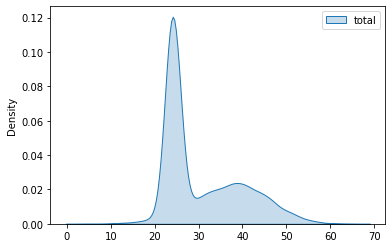

In [44]:
sns.kdeplot(data=total_shifts_pd,fill=True)

In [38]:
hypers

{'soap_type': 'PowerSpectrum',
 'interaction_cutoff': 6.0162081478510965,
 'max_radial': 8,
 'max_angular': 8,
 'gaussian_sigma_constant': 0.2687521416964727,
 'gaussian_sigma_type': 'Constant',
 'radial_basis': 'GTO',
 'normalize': True,
 'cutoff_smooth_width': 0.3,
 'cutoff_function_type': 'RadialScaling',
 'optimization': {'RadialDimReduction': {'projection_matrices': {'1': [[[0.8400778931733396,
       0.4412173105917629,
       0.06881148411780058,
       0.02735917838695556,
       0.033139170964546126,
       0.0944783819045445,
       0.09592091750848371,
       0.13442216361470344,
       0.13684178826095786,
       0.11443806132332539,
       0.09166830222204785,
       0.07379121889846489,
       0.06320493598645305,
       0.05104630333945201,
       0.0406878705167208,
       0.036097824427603405,
       0.030537508857802317,
       0.021512204996477147,
       0.012464078083261573,
       0.006211645642714326],
      [0.253937928802236,
       0.13490852742353648,
       

9.319419177262821